# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

# <font color=red>Step 0: mySQL DB Setup -</font> Script 0
## *The following script sets up the schema for our vizphiz database.*
```

In [ ]:
#All neccessary packages to import for data process steps.
import mysql
import mysql.connector
#install mysql-connector-python // NOT mysql-connector
import re
import os
import datetime 
import subprocess

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password= "Geass5566!!")

mycursor = mydb.cursor()

try:
  mycursor.execute("""
  DROP DATABASE vizphiz_db;
  """)
  mydb.commit() 
except:
  "vizphiz_db does not yet exist!"
  pass

mycursor.execute("""
CREATE DATABASE vizphiz_db;
""")
mydb.commit() 

mycursor.execute("""
USE vizphiz_db;
""")
mydb.commit() 


mycursor.execute("""
CREATE TABLE lamdamax
(
id int unsigned not null primary key,
genus varchar(50),
species varchar(50),
celltype varchar(50),
cellsubtype varchar(50),
lamdamax decimal(9,5),
error decimal(9,5),
chromophore varchar(50),
method varchar(50),
stage varchar(50),
refid int,
notes varchar(1000)
);
""")
mydb.commit() 


mycursor.execute("""
CREATE TABLE heterologous
(
hetid int unsigned not null primary key,
genus varchar(50),
species varchar(50),
accession varchar(500),
mutations varchar(500),
lamdamax decimal(9,5),
error decimal(9,5),
cellculture varchar(50),
purification varchar(50),
spectrum varchar(50),
sourcetype varchar(50),
refid int,
notes varchar(1000)
);
""")
mydb.commit() 


mycursor.execute("""
CREATE TABLE links
(
linkid int unsigned not null primary key,
accession varchar(500),
maxid int,
refid int,
evidence varchar(1000)
);
""")
mydb.commit() 


mycursor.execute("""
CREATE TABLE search
(
searchid int unsigned not null primary key,
researcher varchar(50),
month int,
year int,
engine varchar(500),
keywords varchar(500)
);
""")
mydb.commit() 


mycursor.execute("""
CREATE TABLE opsins
(
opsinid int unsigned not null primary key,
genefamily varchar(50),
genenames varchar(50),
genus varchar(50),
phylum varchar(25),
species varchar(50),
db varchar(50),
accession varchar(500),
dna varchar(10000),
aa varchar(3333),
refid int
);
""")

mydb.commit()

mycursor.execute("""
CREATE TABLE refs
(
refid int,
doilink varchar(100),
searchid int
);
""")
mydb.commit()

mydb.close()

In [ ]:
#All neccessary packages to import for data process steps.
import mysql
import mysql.connector
#install mysql-connector-python // NOT mysql-connector
import re
import os
import datetime 
import subprocess

# <font color=red>STEP 0: Data Base Setup -</font> Script 1 - Import heterologous.tsv into mySQL


In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO vizphiz_db.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[12])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

# <font color=red>STEP 0: Data Base Setup -</font> Script 2 - Import opsindb.tsv into mySQL

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('opsindb.tsv', 'r')
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")

    mycursor = mydb.cursor()

    sql = "INSERT INTO vizphiz_db.opsins (opsinid, genefamily, genenames, genus, species, db, accession, dna, aa, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")



# <font color=red>STEP 1: Extract Data From Vizphiz</font>
### Output = 5 different 'versions' // 'splits' of the data. 
### !Take outputs and run through MAFFT before moving on to STEP2!
### Suggested parameters for 'mafft' alignment are...
1. Fasta Format (Sorted)

2. Strategy = FFT-NS-2 // G-INS-1

In [ ]:
#All neccessary packages to import for data process steps.
import mysql
import mysql.connector
#install mysql-connector-python // NOT mysql-connector
import re
import os
import datetime 
import subprocess

In [ ]:
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
rod = re.compile('Rh[0-2]|exoRh')
d = re.compile("^NM_001014890.2$|^NM_001014890$")
iec = re.compile("Limenitis|Papilio")

In [ ]:
#directory preperation
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seq_report_dir = str(f'vizphiz_data_splits_{dt_label}')
os.makedirs(seq_report_dir)

wd_output = f'{seq_report_dir}/wds.txt'
sws_output = f'{seq_report_dir}/swd.txt'
mws_output = f'{seq_report_dir}/mwd.txt'
rod_output = f'{seq_report_dir}/rod.txt'
wd_ni_output = f'{seq_report_dir}/wds_ni.txt'
inv_output = f'{seq_report_dir}/inv_only.txt'
nmoc_output = f'{seq_report_dir}/nmoc.txt'
wh_metadata = f'{seq_report_dir}/wds_meta.tsv'
sw_metadata = f'{seq_report_dir}/sws_meta.tsv'
mw_metadata = f'{seq_report_dir}/mws_meta.tsv'
rh_metadata = f'{seq_report_dir}/rod_meta.tsv'
wd_ni_metadata = f'{seq_report_dir}/wds_ni_meta.tsv'
inv_metadata = f'{seq_report_dir}/inv_meta.tsv'
nmoc_metadata = f'{seq_report_dir}/nmoc_meta.tsv'

meta_data_list = [wh_metadata,sw_metadata,mw_metadata,rh_metadata,wd_ni_metadata,inv_metadata,nmoc_metadata]

m = 0
s = 0
l = 0
r = 0
c = 0
z = 0
q = 0


In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax,o.aa,o.phylum from vizphiz_db.opsins o, vizphiz_db.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()


for x in myresult:       
#REG-DATA SECTION
  if (x[4] == 0):
    pass
  else:    
    with open(wd_output, 'a') as f:
      if m == 0:
        f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
      if (d.match(x[3])):
        pass
      else:
        m += 1 
        #This makes the fasta format file
        seq = ">S" + str(m)
        f.write(seq)
        seq2 = str('\n' + x[5] + '\n')
        f.write(seq2)

    with open(wd_ni_output, 'a') as f:
      p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
      if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0])):
        pass
      else:
        if c == 0:
          f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
        c += 1 
        #This makes the fasta format file
        seq = ">S" + str(c)
        f.write(seq)
        seq2 = str('\n' + x[5] + '\n')
        f.write(seq2)

    with open(inv_output, 'a') as f:
      p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
      if (p.match(x[2]) or iec.match(x[0])):
        if q == 0:
          f.write(">Squid\nMGRDLRDNETWWYNPSIVVHPHWREFDQVPDAVYYSLGIFIGICGIIGCGGNGIVIYLFTKTKSLQTPANMFIINLAFSDFTFSLVNGFPLMTISCFLKKWIFGFAACKVYGFIGGIFGFMSIMTMAMISIDRYNVIGRPMAASKKMSHRRAFIMIIFVWLWSVLWAIGPIFGWGAYTLEGVLCNCSFDYISRDSTTRSNILCMFILGFFGPILIIFFCYFNIVMSVSNHEKEMAAMAKRLNAKELRKAQAGANAEMRLAKISIVIVSQFLLSWSPYAVVALLAQFGPLEWVTPYAAQLPVMFAKASAIHNPMIYSVSHPKFREAISQTFPWVLTCCQFDDKETEDDKDAETEIPAGESSDAAPSADAAQMKEMMAMMQKMQQQQAAYPPQGYAPPPQGYPPQGYPPQGYPPQGYPPQGYPPPPQGAPPQGAPPAAPPQGVDNQAYQA\n")
        q += 1 
        #This makes the fasta format file
        seq = ">S" + str(q)
        f.write(seq)
        seq2 = str('\n' + x[5] + '\n')
        f.write(seq2)
      else:
          pass

    with open(nmoc_output, 'a') as f:
      p = re.compile('[G,A,L,M,F,W,K,Q,E,S,P,V,I,C,Y,H,R,N,D,T][0-9]+[G,A,L,M,F,W,K,Q,E,S,P,V,I,C,Y,H,R,N,D,T]')
      if (p.search(x[3]) or "-" in x[3]):
        pass
      else:
        if z == 0:
          f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
        if(d.match(x[3])):
          pass
        else:
          z += 1 
          #This makes the fasta format file
          seq = ">S" + str(z)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

    with open(sws_output, 'a') as f:
      p = re.compile('^SWS|^UVS')
      if p.match(x[2]):
        s+=1
        if s == 1:
          f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")  
      #This makes the fasta format file
        seq = ">S" + str(s)
        f.write(seq)
        seq2 = str('\n' + x[5] + '\n')
        f.write(seq2)

    with open(mws_output, 'a') as f:
      p = re.compile('^MWS|^LWS')
      if p.match(x[2]):
        l+=1
        if l == 1:
          f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
        #This makes the fasta format file
        seq = ">S" + str(l)
        f.write(seq)
        seq2 = str('\n' + x[5] + '\n')
        f.write(seq2)

    with open(rod_output, 'a') as f:
      p = re.compile('Rh[0-2]|exoRh')
      if p.match(x[2]):
        if r == 0:
          f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
        if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0])):
          pass
        else:
          r+=1
          #This makes the fasta format file
          seq = ">S" + str(r)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

  #METADATA SECTION
    with open(wh_metadata, 'a') as g:
      if m == 1:
        g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
        g.write("Bovine\t500\tBos_tarus.0000\tRh1\tNM_001014890\n")
      if (d.match(x[3])):
        pass
      else:        
        md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
        g.write(md)

    with open(wd_ni_metadata, 'a') as g:
      p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
      if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0])):
        pass
      else:
        if c == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")

        md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
        g.write(md)

    with open(inv_metadata, 'a') as g:
      p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
      if (p.match(x[2]) or iec.match(x[0])):
        if q == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          g.write("Squid\t473.0000\tTodarodes_pacificus\tRh1\tX70498\n")

        md =  str("S" + str(q) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
        g.write(md)
      else:
        pass
          
    with open(sw_metadata, 'a') as g:
    #This makes the metadata formatted for a linear regression model.
      p = re.compile('^SWS|^UVS')
      if p.match(x[2]):
        if s == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")  
        md =  str("S" + str(s) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
        g.write(md)

    with open(mw_metadata, 'a') as g:
      #This makes the metadata formatted for a linear regression model.
      p = re.compile('^MWS|^LWS')
      if p.match(x[2]):
        if l == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")  
        md =  str("S" + str(l) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
        g.write(md)

    with open(rh_metadata, 'a') as g:
      #This makes the metadata formatted for a linear regression model.
      p = re.compile('Rh[0-3]|exoRh')

      if p.match(x[2]):
        if r == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")
        if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0])):
          pass
        else:  
          md =  str("S" + str(r) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

    with open(nmoc_metadata, 'a') as g:
      p = re.compile('[G,A,L,M,F,W,K,Q,E,S,P,V,I,C,Y,H,R,N,D,T][0-9]+[G,A,L,M,F,W,K,Q,E,S,P,V,I,C,Y,H,R,N,D,T]')
      if (p.search(x[3]) or "-" in x[3]):
        pass
      else:
        if z == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")
        if(d.match(x[3])):
          pass
        else:        
          md =  str("S" + str(z) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

In [ ]:
msp_erg_raw = open('./msp_test_data/msp_erg_raw.txt').readlines()
for lines in msp_erg_raw:
  with open(wd_output, 'a') as f:
    f.write(lines)
  with open(wd_ni_output, 'a') as f:
    f.write(lines)
  with open(rod_output, 'a') as f:
    f.write(lines)
  with open(nmoc_output, 'a') as f:
    f.write(lines)
  with open(inv_output, 'a') as f:
    f.write(lines)
  with open(mws_output, 'a') as f:
    f.write(lines)
  with open(sws_output, 'a') as f:
    f.write(lines)


# <font color=red>STEP 2: Align Raw Data and Format for 'deepBreaks'</font>
## REMINDER - You will need to change the directory for the 'mafft_exe' variable to the one of your own operating system!


In [ ]:
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO

data_split_list = [wd_output,sws_output,mws_output,rod_output,wd_ni_output,inv_output,nmoc_output]
output_list = []
mafft_exe = 'C:/Users/safra/mafft-win/mafft.bat' 

for data in data_split_list:
    output = f'{data.split(".")[0]}_aligned.txt'
    mafft_cline = MafftCommandline(mafft_exe, input= f'./{data}')
    print(mafft_cline)

    stdout, stderr = mafft_cline()

    with open(output, "w") as handle:
        handle.write(stdout)
    align = AlignIO.read(output, "fasta")
    output_list.append(f'{output}')


In [ ]:
print(output_list)

for item in output_list:
    output = item.split('.')[0]
    print(output)

In [ ]:
#enter list of aligned text files here.
inputs = output_list
deep_breaks_input_data = []
# inputs = ['wds_aligned.txt','wds_ni_aligned.txt','rod_aligned.txt','nmoc_aligned.txt']
##enter list of names for desired formatted fasta files here.
# output = ['wds_fmt.fasta','wds_ni_fmt.fasta','rod_fmt.fasta','nmoc_fmt.fasta']
i=0
k = 0
for item in inputs:
    print(item)
    lines = open(inputs[i]).readlines()
    output = f'./{inputs[i].split(".")[0]}_db_fmt.fasta'
    deep_breaks_input_data.append(output)
    print(output)
    file = open(output, 'w')
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

In [ ]:
print(deep_breaks_input_data)

# <font color=red>STEP 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
### STEP 4 doesn't start until Cell 34

In [3]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import numpy as np
import csv
import pandas as pd
import warnings
import datetime
import os
import shutil
import time

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [ ]:
predictions_list = []

# defining user params, file pathes, analysis type

# path to sequences
seqFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/wds_aligned_db_fmt.fasta"

# path to metadata
metaDataFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/wds_meta.tsv"

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.6

print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
metaFile = metaDataFileName.split('/')[1]
# importing sequences data
print('reading fasta file')
ref_df = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
#merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
ref_df= ref_df.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
#tr.shape

test_iter = 0
first_run = 0
umd = []


In [ ]:
full_df = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
#merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
full_df= full_df.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
full_df.drop(mt, axis=1, inplace=True)

In [ ]:
while ref_df.shape[0]>0:
    tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
    #merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
    tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
    #tr.shape
    # making a unique directory for saving the reports of the analysis
    print('direcory preparation')
    dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    seqFile = seqFileName.split('/')[2]
    print(seqFile)
    seqFile = seqFile.split('.')[0]
    print(seqFile)
    report_dir = str(seqFile +'_' + mt + '_' + dt_label)
    os.makedirs(report_dir)

    #creating a copy of the input fasta file and metadata file into the report directory
    shutil.copy2(f'{seqFileName}' , report_dir)
    shutil.copy2(f'{metaDataFileName}' , report_dir)

    #changing the number of test sequences to extract from the training dataframe based on the size of the training dataset
    if tr.shape[0] <= 150:
        sample_n = 15
    elif tr.shape[0] > 150 and tr.shape[0] <= 300:
        sample_n = 25
    elif tr.shape[0] > 300 and tr.shape[0] <= 1000:
        sample_n = 50
    else:
        sample_n = 100

    n=0
    while n<1:
        try:
            drop_indices = np.random.choice(ref_df.index, sample_n, replace=False)
            #print(drop_indices)
            ref_df = ref_df.drop(drop_indices)
            n+=1
        except:
            sample_n = ref_df.shape[0]

    #copying the sampled indices into a seperate dataframe to act as our 'unseen' test data later
    unseen = tr.loc[drop_indices].copy()
    umd.extend(unseen.loc[:, mt].values)
    #dropping our sample indices from the training dataframe
    unseen.drop(mt, axis=1, inplace=True)
    tr = tr.drop(drop_indices)

    if first_run == 0:
        base_test = meta_data.loc[drop_indices].copy()
        first_run+=1
    else:
        # Use the loc method to add the new row to the DataFrame
        base_test = base_test.append(meta_data.loc[drop_indices].copy())
        print(len(base_test))

    y = tr.loc[:, mt].values
    tr.drop(mt, axis=1, inplace=True)

    #settingthe paramaters for our ML pipeline
    prep_pipeline = make_pipeline(
        steps=[
            ('mc', MisCare(missing_threshold=0.05)),
            ('cc', ConstantCare()),
            ('ur', URareCare(threshold=0.025)),
            ('cc2', ConstantCare()),
            ('one_hot', CustomOneHotEncoder()),
            ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
            ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.05, keep=False))
        ])

    #training models
    report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                                models_dict=get_models(ana_type=ana_type),
                                scoring=get_scores(ana_type=ana_type),
                                report_dir=report_dir,
                                cv=12, ana_type=ana_type, cache_dir=report_dir)

                                
    time.sleep(1)
    #setting parameters for tuning the top 3 performing models
    prep_pipeline = make_pipeline(
        steps=[
            ('mc', MisCare(missing_threshold=0.05)),
            ('cc', ConstantCare()),
            ('ur', URareCare(threshold=0.025)),
            ('cc2', ConstantCare()),
            ('one_hot', CustomOneHotEncoder()),
            ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
            ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.05, keep=True))
        ])

    modified_top = []
    mtml = []
    for model in top:
        modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
        my_top_models = str(model[1:])
        #print(my_top_models)
        my_top_models = my_top_models.split("'")[3]
        mtml.append(my_top_models)
        #print(my_top_models)

    #print(mtml)
    time.sleep(1)

    #tuning the top 3 performing models 
    top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_params(),report_dir=report_dir, cv=10)
    #summarize the results by extracting feature importance and p-values and grouping correlated features.
    sr = summarize_results(top_models=top, report_dir=report_dir)
    #plot a scatter plot with -log of (p-value) column as the x-axis and the values of the other columns 
    scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

    time.sleep(1)

    #plot mean relative importance of each feature - corresponding to an amino acid position.
    mean_imp = mean_importance(top, report_dir=report_dir)

    dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)
    tr = prep_pipeline[:4].fit_transform(tr)

    for model in top:
        model_name = model.steps[-1][0]
        dp_plot(importance=importance_from_pipe(model),
                imp_col='standard_value',
                model_name = model_name, report_dir=report_dir)
        
        plot_imp_model(importance=importance_from_pipe(model), 
                X_train=tr, y_train=y, model_name=model_name,
                    meta_var='meta', model_type=ana_type, report_dir=report_dir)

    time.sleep(1)
                    

    from deepBreaks.utils import load_obj
    import joblib
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.metrics import mean_squared_error

    plt.show()
    plt.clf()

    #load and test the top performing linear regression model.
    top_per_mod = report_dir + '/' + mtml[0] + '.pkl'
    load_rf = load_obj(top_per_mod)
    time.sleep(3)
    predictions = load_rf.predict(unseen)
    predictions_list.extend(predictions)
    #print(predictions)
   
    #cycling to next set of data split files.
    #opsin_data_count+=1


In [2]:
from scipy import stats
import re
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from deepBreaks.preprocessing import read_data

In [ ]:
predictions_list2 = []
for pred in predictions_list:
    p = float(pred)
    predictions_list2.append(p)
umd2 = []
for lmax in umd:
    p = float(lmax)
    umd2.append(p)


In [ ]:
#adding in the predicted lamda max into the test df
base_test['Prediction'] = predictions_list
#adding the difference between predicted and known lambda max into df
base_test['Difference'] = base_test['Prediction'] - base_test['Lambda_Max']
base_test = base_test[['Species', 'Opsin_Family', 'Accession','Lambda_Max','Prediction','Difference']]
#writing df to a csv file for secondary analysis in report directory
base_test.to_csv(path_or_buf= f'{report_dir}/basetest_results.csv',index = 'Feature',mode="w")

edgecolors = []
colors = []
for ind in base_test.index:
    if abs(base_test['Difference'][ind]) >= 10:
        edgecolors.append('k')
        if base_test['Phylum'][ind] == 'Chordata':
            if '-' in base_test['Accession'][ind]:
                colors.append('#2166ac')
            elif base_test['Accession'][ind].count('_') > 1 or base_test['Accession'][ind].count(',') >= 1:
                p = re.compile('^.._')
                if p.match(base_test['Accession'][ind]) and base_test['Accession'][ind].count('_') == 2:
                    colors.append('#d1e5f0')
                else:
                    colors.append('#67a9cf')
            elif base_test['Accession'][ind].count('_') == 0 and base_test['Accession'][ind].count(',') == 0:
                colors.append('g')
            else:
                colors.append('#d1e5f0')
        else:
            if '-' in base_test['Accession'][ind]:
                #red
                colors.append('#d73027')
            elif base_test['Accession'][ind].count('_') > 1 or base_test['Accession'][ind].count(',') > 1:
                p = re.compile('^.._')
                if p.match(base_test['Accession'][ind]) and base_test['Accession'][ind].count('_') == 2:
                    #yellow
                    colors.append('#fee090')
                else:
                    #orange
                    colors.append('#fc8d59')
            elif base_test['Accession'][ind].count('_') == 0 and base_test['Accession'][ind].count(',') == 0:
                #purple
                colors.append('#7900A9')
            else:
                #yellow
                colors.append('#fee090')
    else:
        colors.append('#f0f0f0')
        edgecolors.append('#c9c9c9')

#Make edits to code to account for wildtypes!

#MAKE THIS A FUCNTION!?!?!? vvv
#plotting the predicted vs. known lambda max values
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
plt.title("$λ_{max}$ Predictions for Whole Opsin Dataset")
plt.scatter(umd, predictions_list, c=colors, ec = edgecolors, edgecolors='k', s = 35)
plt.plot(umd, umd, c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

plt.annotate(f"$R^2$ = {stats.linregress(umd2,predictions_list2)[2]:.3f}",(min(umd), (max(umd) - ((max(umd) - min(umd)) *  0.15))), fontsize = 20, c = 'k')
#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{report_dir}/hetero_diff.pdf'
plt.savefig(fileout)
fileout = 'f{report_dir}/hetero_diff.png'
plt.savefig(fileout)
plt.show()
plt.clf()

time.sleep(1)

#calculating r^2, mae, mape, sqe, and rsque for the model on our subsample of extracted test data
model_testing__report = f'{report_dir}/model_testing report.tsv'
base_rsq = stats.linregress(umd2,predictions_list2)[2]
print(base_rsq)
base_mae = mean_absolute_error(predictions_list,umd)
#print(base_mae)
base_mape = mean_absolute_percentage_error(predictions_list,umd)
#print(base_mape)
base_sqe = mean_squared_error(predictions_list,umd)
#print(base_sqe)
base_rsqe = mean_squared_error(predictions_list,umd, squared = False)
#print(base_rsqe)
with open(model_testing__report , 'a') as f:
    f.write(f'Base Model R^2\tMAE\tMAPE\tSQE\tRSQE\n')
    f.write(f'{str(base_rsq)}\t{str(base_mae)}\t{str(base_mape)}\t{str(base_sqe)}\t{str(base_rsqe)}')

In [ ]:

#MAKE THIS A FUCNTION!?!?!? vvv
#plotting the predicted vs. known lambda max values
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
plt.title("$λ_{max}$ Predictions for Whole Opsin Dataset")
plt.scatter(umd, predictions_list, c='#d1e5f0', ec = 'black', edgecolors='k', s = 35)
plt.plot(umd, umd, c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

plt.annotate(f"$R^2$ = {stats.linregress(umd2,predictions_list2)[2]:.3f}",(min(umd), (max(umd) - ((max(umd) - min(umd)) *  0.15))), fontsize = 20, c = 'k')
#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{report_dir}/hetero_uniform.pdf'
plt.savefig(fileout)
fileout = 'f{report_dir}/hetero_uniform.png'
plt.savefig(fileout)
plt.show()
plt.clf()

In [3]:
directory = './results_4_paper/full_iter_sample_tests/'
metaDataFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/wds_ni_meta.tsv"
testFileName = f"{directory}vert_test_results.csv"
phylum_list = []
data_set = 'vert2'

meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
base_test = read_data(testFileName, seq_type = None, is_main=False)

for phyla in base_test.index:
    #print(phyla)
    phylum_list.append(meta_data.Phylum[phyla])
#print(phylum_list)


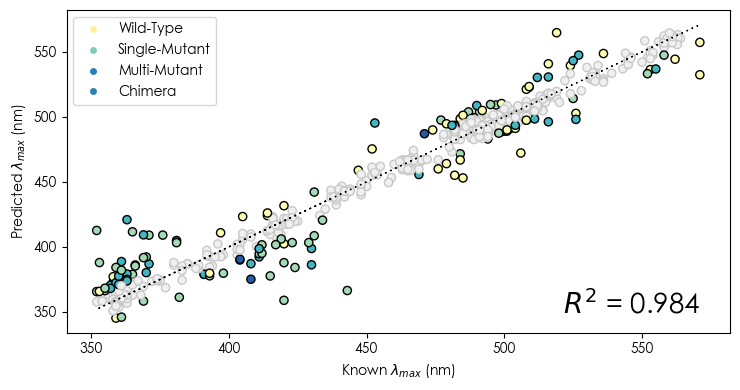

<Figure size 750x400 with 0 Axes>

In [5]:
#adding in the predicted lamda max into the test df
#adding the difference between predicted and known lambda max into df
base_test['Phylum'] = phylum_list
edgecolors = []
colors = []
for ind in base_test.index:
    if abs(base_test['Difference'][ind]) >= 10:
        edgecolors.append('k')
        if base_test['Phylum'][ind] == 'Chordata':
        #Vertebrate Opsins
            if '-' in base_test['Accession'][ind]:
                #dark blue - chimeras
                colors.append('#225ea8')
            elif base_test['Accession'][ind].count('_') > 1 or base_test['Accession'][ind].count(',') >= 1:
                p = re.compile('^.._')
                if p.match(base_test['Accession'][ind]) and base_test['Accession'][ind].count('_') == 2:
                    #medium blue - one mutation
                    colors.append('#a1dab4')
                    
                else:
                    #dark blue - multiple mutations
                    colors.append('#41b6c4')
            elif base_test['Accession'][ind].count('_') == 0 and base_test['Accession'][ind].count(',') == 0:
                #light-yellow - WT
                colors.append('#ffffb2')
            else:
                #medium blue - one mutation
                colors.append('#a1dab4')
                
        else:
            #Invertebrate opsins
            if '-' in base_test['Accession'][ind]:
                #purple - chimera
                colors.append('#7900A9')
                
            elif base_test['Accession'][ind].count('_') > 1 or base_test['Accession'][ind].count(',') > 1:
                p = re.compile('^.._')
                if p.match(base_test['Accession'][ind]) and base_test['Accession'][ind].count('_') == 2:
                    #orange - one mutation 
                    colors.append('#fc8d59')
                else:
                    #red - mutiple mutations
                    colors.append('#d73027')
            elif base_test['Accession'][ind].count('_') == 0 and base_test['Accession'][ind].count(',') == 0:
                #yellow - WT
                colors.append('#fee090')
            else:
                #orange - One mutation
                colors.append('#fc8d59')
    else:
        colors.append('#f0f0f0')
        edgecolors.append('#c9c9c9')

#plotting the predicted vs. known lambda max values...

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Vertebrate Opsin Dataset")
plt.scatter(base_test['Lambda_Max'], base_test['Prediction'], c=colors, ec = edgecolors, edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#ffeda0', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#7fcdbb', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12)]
legend_labels = ['Wild-Type','Single-Mutant', 'Multi-Mutant', 'Chimera']

# Adjust bbox_to_anchor values to place the legend inside the graph
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

#plot and adjust position of the R^2 value
#plt.text(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]:.3f}", ha='right', va='bottom', fontsize=20, c='k')
plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]:.3f}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')

#plt.xticks(range(min(umd), max(umd)+1))
fileout = 'vert_iter_test.pdf'
plt.savefig(fileout)
fileout = 'vert_iter_test.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

base_test['Colors'] = colors
base_test = base_test[['Species', 'Phylum', 'Opsin_Family', 'Accession','Lambda_Max','Prediction','Difference','Colors']]
#writing df to a csv file for secondary analysis in report directory
base_test.to_csv(path_or_buf= f'{directory}revised_basetest_results.csv',index = 'Feature',mode="w")